### Hi there! this is the notebook code of the paper: "Exploring the link between cation exchange capacity and magnetic susceptibility"

In [1]:
from plots import *
from utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr
import itertools

# Get notebook and parent dir
current_dir = os.path.dirname(os.path.abspath('__file__')) 
parent_dir = os.path.dirname(current_dir)

np.set_printoptions(precision=2)

In [2]:
datafolder = 'data' # data folder
file_path = os.path.join(datafolder, "MS_text_XRF_hydr.csv")
df = pd.read_csv(file_path, sep=',', header=0)

df['EC'] = logsdon(50e6, df.field_realperm, df.field_imperm)*1000
#df.describe()

df.head()

,SAMPLE,Depth,K_field,Klf,Mass,Khf,Kfd_abs,Kfd,Fe,horizon,...,CEC,Clay,Silt,Sand,WC,field_realperm,field_imperm,field_temp,EC1_5,EC
0,HOEKE3,55,0.000167,0.000097,14.80,0.000093,0.000005,4.802463,16994.0,NaN,...,7.937,16.102,38.811,45.087,26.71,19.2,15.4,16.3,0.01470,27.060501
1,HOEKE8,28,0.001160,0.001270,13.70,0.001204,0.000061,4.822134,23155.0,NaN,...,13.855,21.728,41.326,36.946,32.85,28.8,27.4,19.7,0.01698,43.537028
2,HOEKE47,63,0.000165,0.000164,13.84,0.000151,0.000013,7.706422,22558.0,NaN,...,14.485,28.995,48.200,22.805,39.09,28.8,26.8,19.3,0.01442,43.169526
3,HOEKE23,80,0.000141,0.000091,14.18,0.000087,0.000004,4.885530,18330.0,NaN,...,9.251,18.817,45.699,35.484,40.62,31.3,22.4,16.5,0.01544,41.833353
4,HOEKE49,107,0.000150,0.000155,14.95,0.000143,0.000012,7.493540,19274.0,NaN,...,9.498,16.878,41.577,41.545,34.92,27.5,23.4,18.2,0.01309,39.759618


In [3]:
median_humus = df['Humus'].median()
top_soil = df[df['Humus'] > median_humus]
sub_soil = df[df['Humus'] <= median_humus]
median_clay = df['Clay'].median()
print('Median of clay content over all data', median_clay)

clayey_soil = df[df['Clay'] > median_clay]
print('samples number in clayey group', len(clayey_soil.Clay.values))

sandy_soil = df[df['Clay'] <= median_clay]
print('samples number in sandy group', len(sandy_soil.Clay.values))
sandy_soil.describe()

Median of clay content over all data 16.102
samples number in clayey group 24
samples number in sandy group 25


,Depth,K_field,Klf,Mass,Khf,Kfd_abs,Kfd,Fe,Bulk_density,copeky_depth,...,CEC,Clay,Silt,Sand,WC,field_realperm,field_imperm,field_temp,EC1_5,EC
count,25.000000,25.000000,25.000000,25.00000,25.000000,2.500000e+01,25.000000,25.00000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,68.160000,0.000098,0.000142,15.43472,0.000133,8.414000e-06,6.398393,9650.15560,1.604542,68.400000,...,3.867240,8.212640,30.274960,61.512600,23.03680,14.804000,6.624000,22.612800,0.005803,14.070628
std,42.359257,0.000088,0.000166,1.18282,0.000159,8.367549e-06,1.808640,6417.89493,0.107922,42.388088,...,2.532982,3.777454,28.677879,31.368223,10.24143,7.493802,6.094074,3.471637,0.003690,11.249481
min,4.000000,0.000008,0.000012,13.40800,0.000011,6.100000e-07,2.891030,1029.00000,1.429074,5.000000,...,1.600000,2.906000,1.068000,8.969000,4.79000,3.000000,0.200000,16.300000,0.001930,0.553454
25%,32.000000,0.000033,0.000046,14.79000,0.000042,2.480000e-06,5.263158,3610.89000,1.513036,32.000000,...,1.600000,5.083000,4.323000,43.190000,19.18000,12.000000,3.300000,20.300000,0.002870,8.455678
50%,60.000000,0.000052,0.000073,15.33000,0.000067,4.680000e-06,6.288344,10557.00000,1.626441,60.000000,...,2.426000,7.897000,16.311000,72.939000,26.05000,16.100000,4.600000,21.900000,0.004140,11.337163
75%,106.000000,0.000142,0.000185,15.90000,0.000170,1.430000e-05,7.904710,15178.00000,1.675356,106.000000,...,5.680000,10.750000,46.533000,91.266000,30.46000,18.800000,10.300000,24.200000,0.008460,21.301062
max,154.000000,0.000320,0.000726,17.96000,0.000702,2.940000e-05,9.754434,21333.00000,1.792090,154.000000,...,8.763000,16.102000,79.997000,94.604000,37.70000,28.000000,21.900000,31.100000,0.014700,39.020700


####  Calculate the Pearson correlation coefficients and p-values


c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


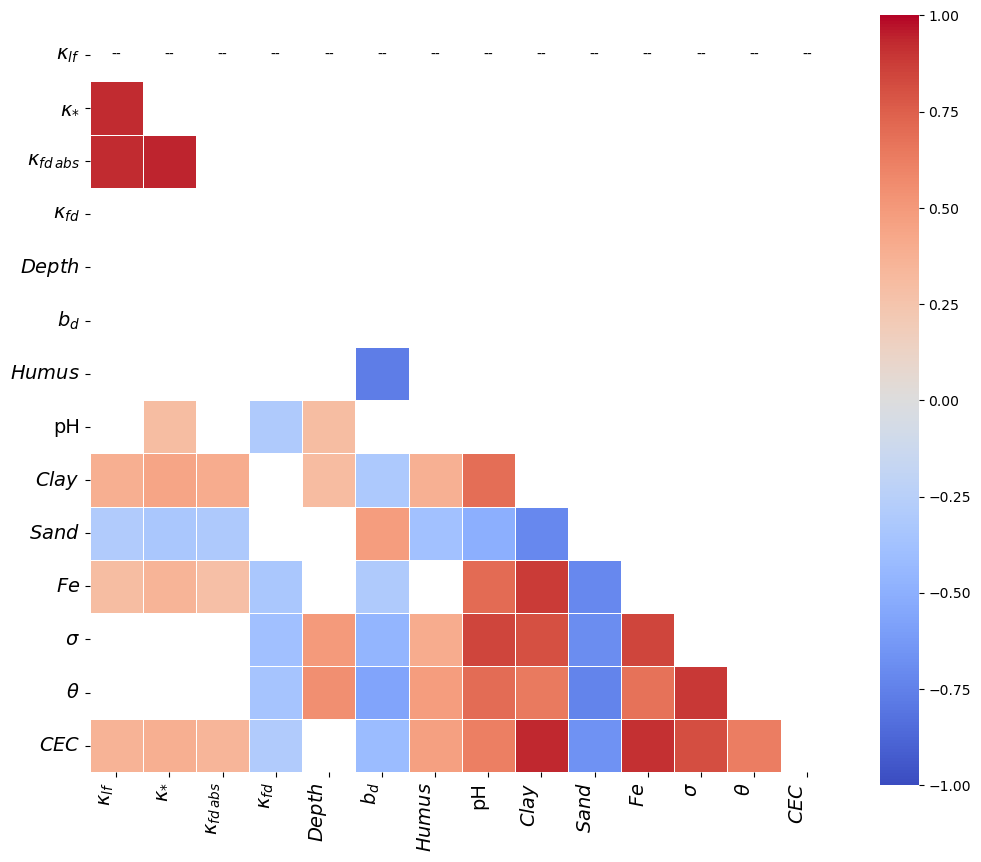

In [4]:
# Define the filtered features
feature_sets_CEC = [
    ['Klf'], ['K_field'], ['Kfd_abs'], ['Kfd'], ['Depth'], ['Bulk_density'], ['Humus'], ['pH_eau'],
    ['Clay'], ['Sand'], ['Fe'], ['EC'], ['WC'], ['CEC']
]

new_labels = [
    r'$\it{\kappa_{lf}}$', r'$\it{\kappa_{*}}$', r'$\it{\kappa_{fd\,abs}}$', '$\it{\kappa_{fd}}$', r'$\it{Depth}$', r'$\it{b_d}$', r'$\it{Humus}$', 'pH',
    r'$\it{Clay}$', r'$\it{Sand}$', r'$\it{Fe}$', r'$\it{\sigma}$',  r'$\it{\theta}$', r'$\it{CEC}$'
]

filtered_features = [f[0] for f in feature_sets_CEC]

# Drop rows with NaN values in the filtered features to handle NaNs
df_filtered = df[filtered_features].dropna()

# Initialize matrices to store Pearson correlation coefficients and p-values
corr = np.zeros((len(filtered_features), len(filtered_features)))
p_value = np.zeros((len(filtered_features), len(filtered_features)))

# Calculate the Pearson correlation coefficients and p-values
for i in range(len(filtered_features)):
    for j in range(len(filtered_features)):
        corr[i, j], p_value[i, j] = pearsonr(df_filtered.iloc[:, i], df_filtered.iloc[:, j])

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=filtered_features, columns=filtered_features)
p_value_df = pd.DataFrame(p_value, index=filtered_features, columns=filtered_features)

# Call the function to plot the correlation matrix
plot_correlation_matrix(corr_df, p_value_df, new_labels)

c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

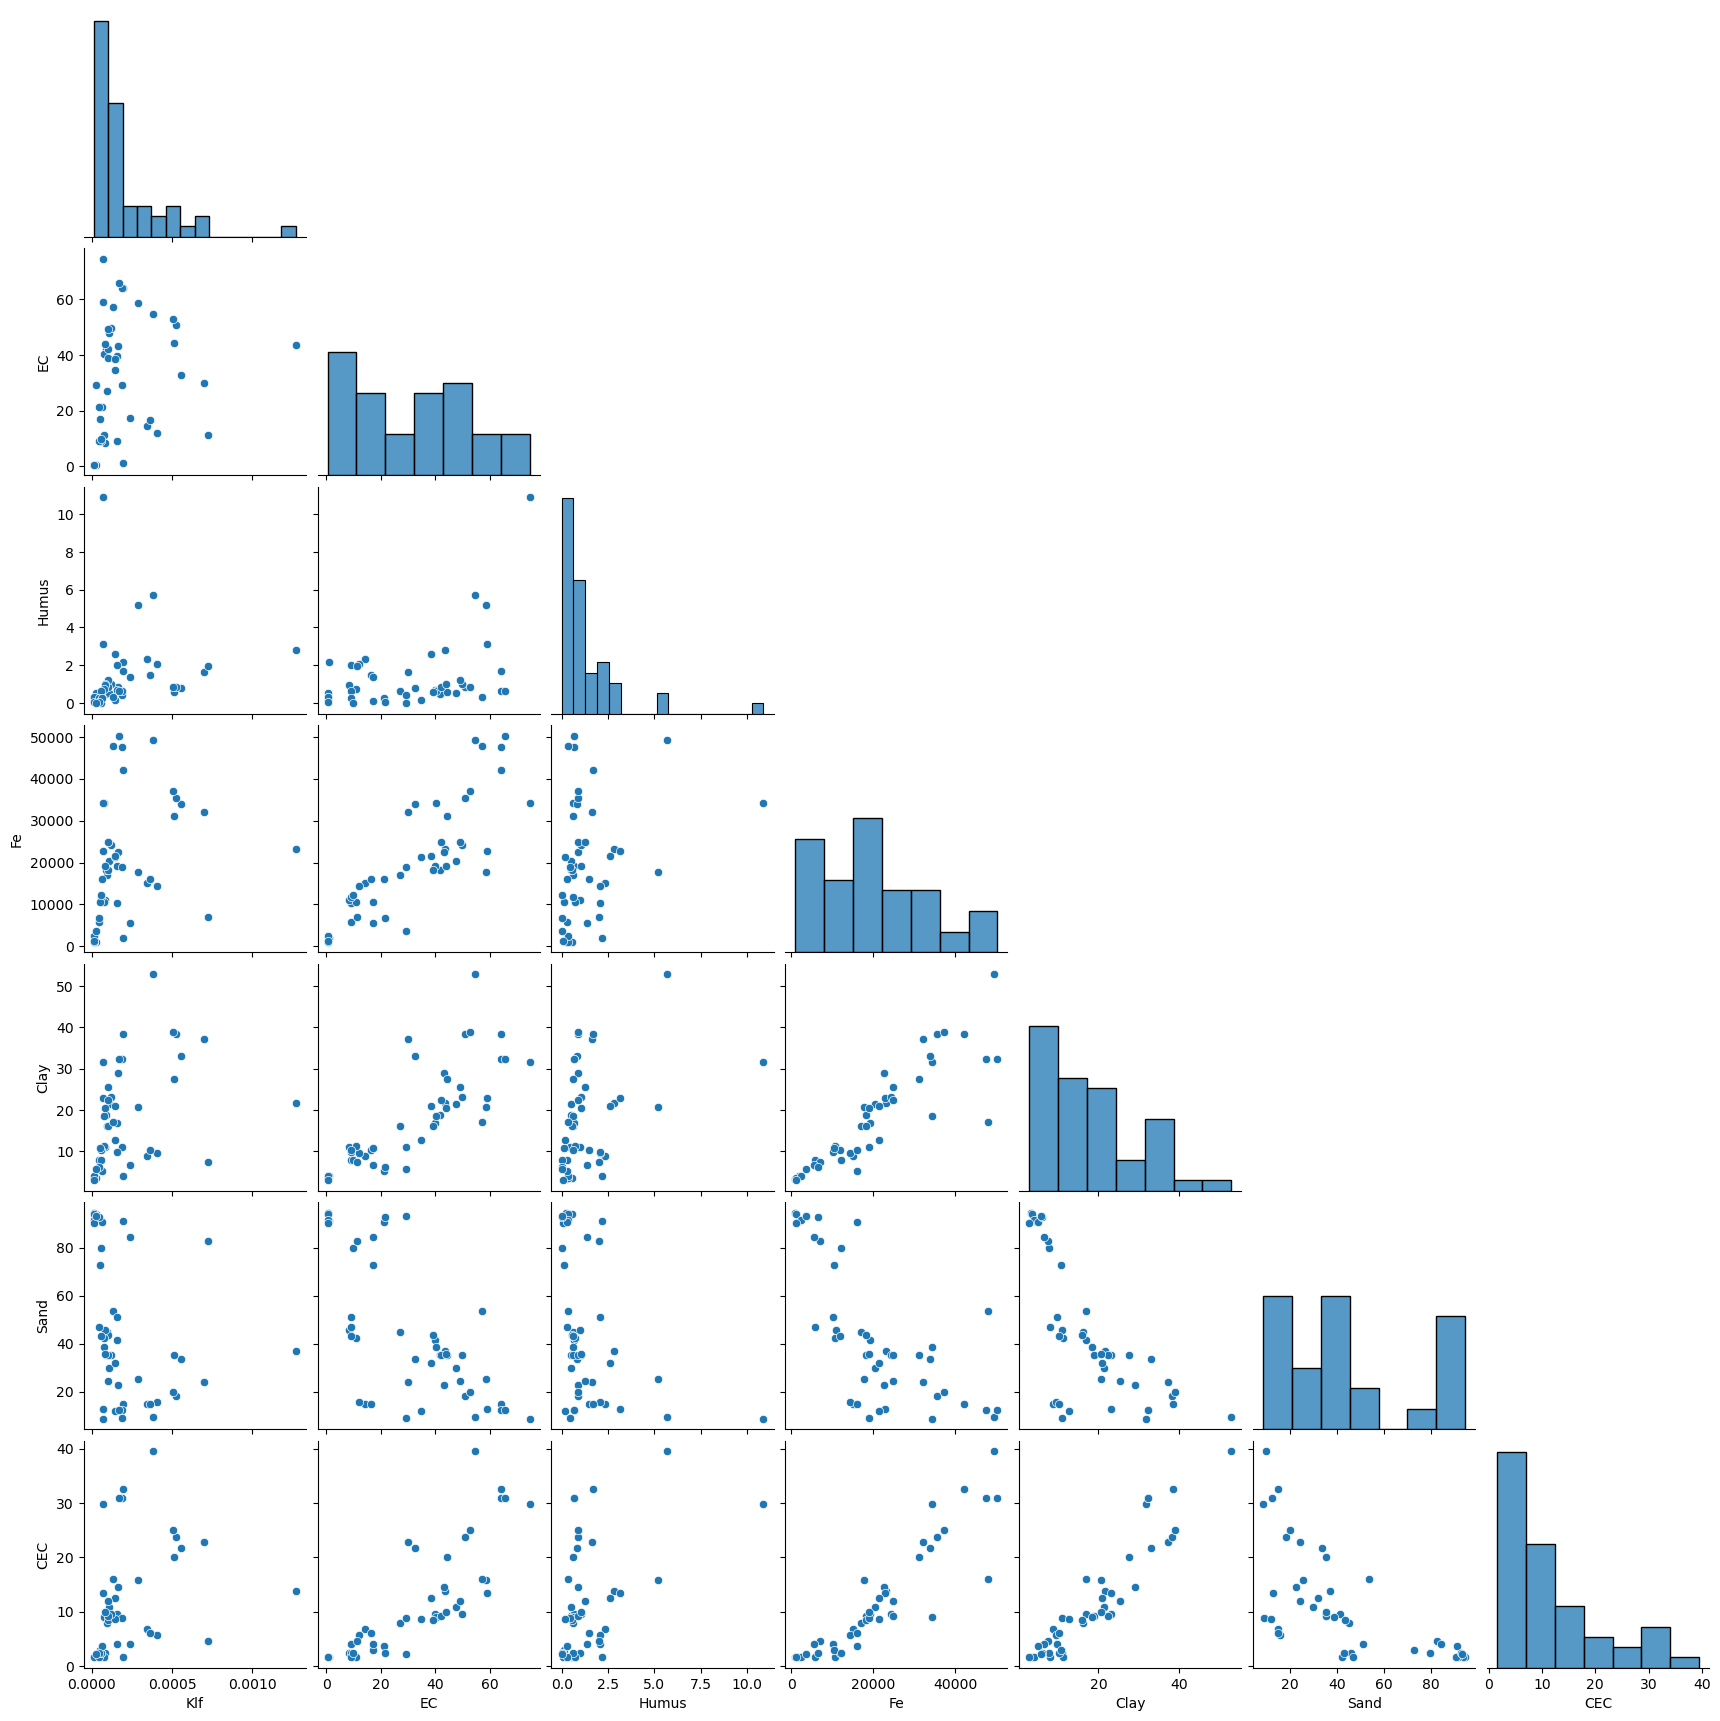

In [5]:
g = sns.pairplot(df.loc[:,['Klf', 'EC', 'Humus', 'Fe', 'Clay', 'Sand', 'CEC']], 
                  diag_kws=dict(fill=True), corner=True)
plt.show()

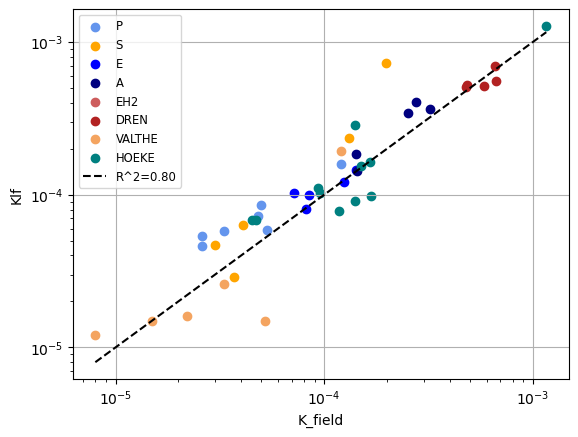

In [6]:
mapping = {
    "P": ("cornflowerblue", "o"),
    "S": ("orange", "o"),
    "E": ("blue", "o"),
    "A": ("navy", "o"),
    "EH2": ("indianred", "o"),
    "DREN": ("firebrick", "o"),
    "VALTHE": ("sandybrown", "o"),
    "HOEKE": ("teal", "o"),
}


plot_sing(df, 'K_field', 'Klf', mapping, onexone_line=True, log_scale=True)

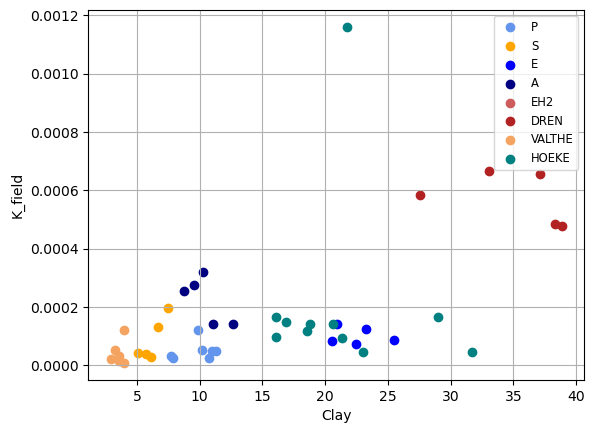

In [7]:
plot_sing(df, 'Clay', 'K_field', mapping)

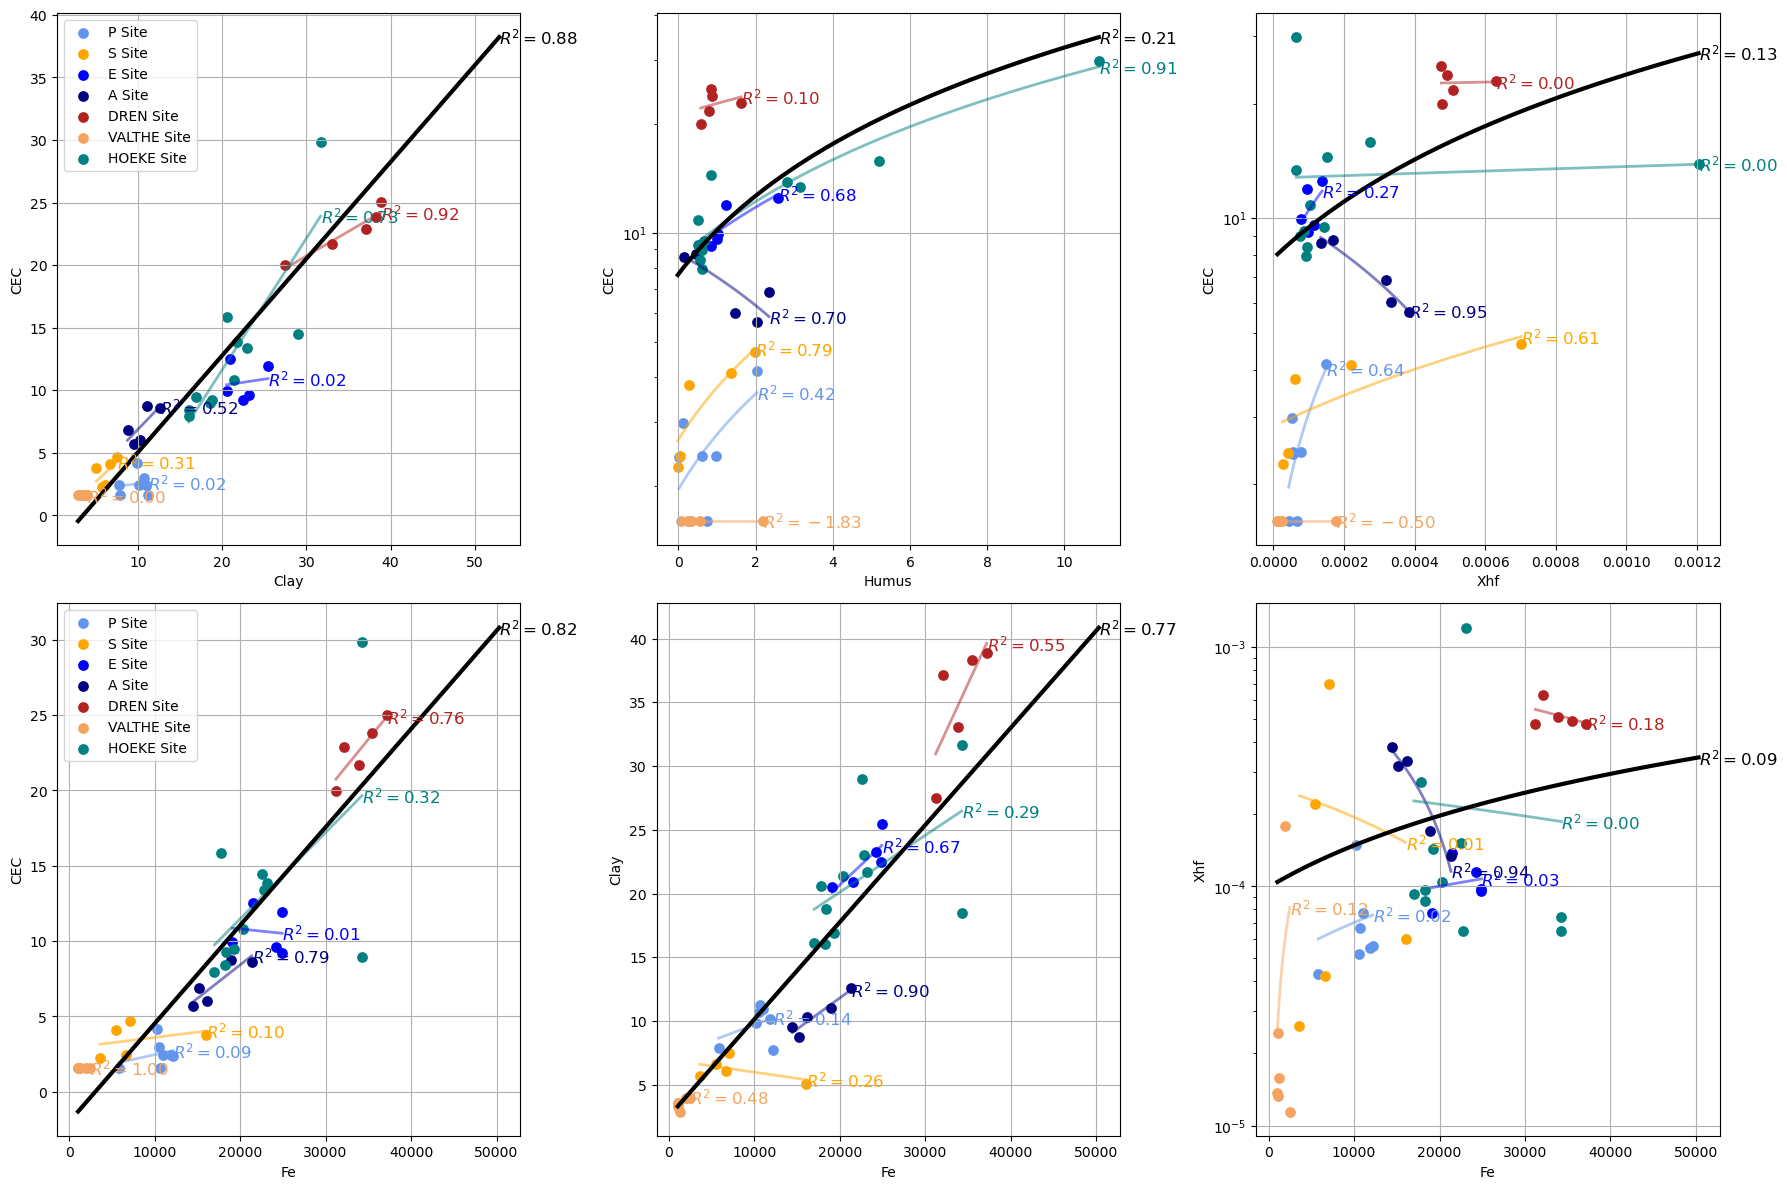

In [8]:
plot_multiple_scatter_plots(df, mapping, plot_data1)

## Linear implementation to predict CEC 
## No train-test


In [9]:
results_r2 = pd.DataFrame(columns=['Clay_Klf', 'Clay_Kfd'])
results_rmse = pd.DataFrame(columns=['Clay_Klf', 'Clay_Kfd'])

## CEC prediction with Train-Test for all samples

In [10]:
feature_sets_CEC = [
    ['Clay'],
    ['Sand'],
    ['K_field'],
    ['Khf'],
    ['Kfd'],
    ['Kfd_abs'],
    ['Depth'],
    ['Bulk_density'],
    ['Humus'],
    ['Fe'],
    ['EC'],
    ['pH_eau'],
    ['WC']
]
i =1
n=4 # How many feature combinations are shown in the horizontal bar plots

# Generate all pairs of features
pair_combinations = list(itertools.combinations([f[0] for f in feature_sets_CEC], 2))

# Convert pairs to the same format as individual features
feature_sets_pairs = [[pair[0], pair[1]] for pair in pair_combinations]

# Combine individual features and pairs into one list
all_feature_sets = feature_sets_CEC + feature_sets_pairs

df_CEC = df['CEC']

# Prepare to store the results for all feature sets
results_summary = []
test_errors_summary = []
train_errors_summary = []
best_n_ = []

# Evaluate all feature sets
for feature_set in all_feature_sets:
    best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(df, feature_set, df_CEC, iters=100)
    print(i, 'best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
    
    # Store results in lists for later use
    best_n_.append(best_n)
    test_errors_summary.append(R2_test_pol)
    train_errors_summary.append(R2_train_pol)
    
    # Also store the results in a structured format for sorting
    results_summary.append({
        'feature_set': feature_set,
        'best_n': best_n,
        'R2_test_pol': R2_test_pol,
        'R2_train_pol': R2_train_pol,
        'RMSE_test_pol': RMSE_test_pol,
        'RMSE_train_pol': RMSE_train_pol
    })
    i+=1
# Keep the lists of feature sets, test errors, and train errors as they are for further use
best_feat_ind = test_errors_summary.index(max(test_errors_summary))
best_feat = all_feature_sets[best_feat_ind]  # Use all_feature_sets to match the order
best_feat_n = best_n_[best_feat_ind]
print('best_feat_ind, best_feat, best_feat_n', best_feat_ind, best_feat, best_feat_n)

# This part remains the same: finding the best feature set and using it in `fit_and_plot`
fit_and_plot(df, best_feat, 'CEC', best_feat_n, mapping, 10)

# Convert the results summary to a DataFrame for sorting and filtering
results_df = pd.DataFrame(results_summary)

1 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.843 0.884 3.623 3.325 ['Clay']
2 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.398 0.51 7.302 6.755 ['Sand']
3 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.133 0.276 8.858 8.304 ['K_field']
4 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.059 0.295 9.489 8.139 ['Khf']
5 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.004 0.07 9.381 9.385 ['Kfd']
6 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.021 0.125 9.218 9.089 ['Kfd_abs']
7 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 -0.029 0.073 9.334 9.435 ['Depth']
8 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.009 0.185 9.152 8.806 ['Bulk_density']
9 best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_tra

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


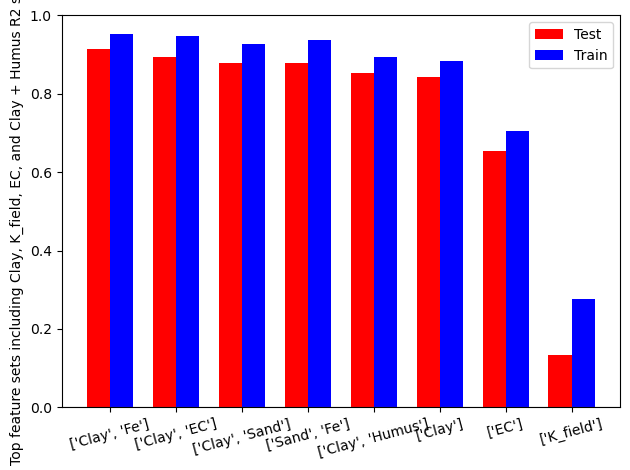

In [11]:
results_df.to_csv('table_outputs/full_results.csv')
# Sort by R2_test_pol in descending order and select the top 4
top_results = results_df.sort_values(by='R2_test_pol', ascending=False).head(n)

# Ensure that 'Clay', 'K_field', 'EC', and 'Clay + Humus' are included
required_features = [['Clay'], ['K_field'], ['EC'], ['Clay', 'Humus']]

# Find the corresponding results for the required features in the original results
for required in required_features:
    required_result = results_df[results_df['feature_set'].apply(lambda x: set(x) == set(required))]
    
    # Append the result for the required feature if it's not already in the top results
    if not required_result.empty and not any(set(required_result['feature_set'].values[0]) == set(x) for x in top_results['feature_set'].values):
        top_results = pd.concat([top_results, required_result])

# Now we ensure that the top 4 feature sets along with the required features are included in the plot
# Sort by R2_test_pol in descending order again to maintain consistency
top_results = top_results.sort_values(by='R2_test_pol', ascending=False)

# Plot the updated top results, which include the top 4 feature sets, and 'Clay', 'K_field', 'EC', and 'Clay + Humus'
bars_plot(top_results['feature_set'].tolist(), 
          top_results['R2_test_pol'].tolist(), 
          top_results['R2_train_pol'].tolist(), 
          'Top feature sets including Clay, K_field, EC, and Clay + Humus')

# CEC prediction with Train and Test for Sandy Group

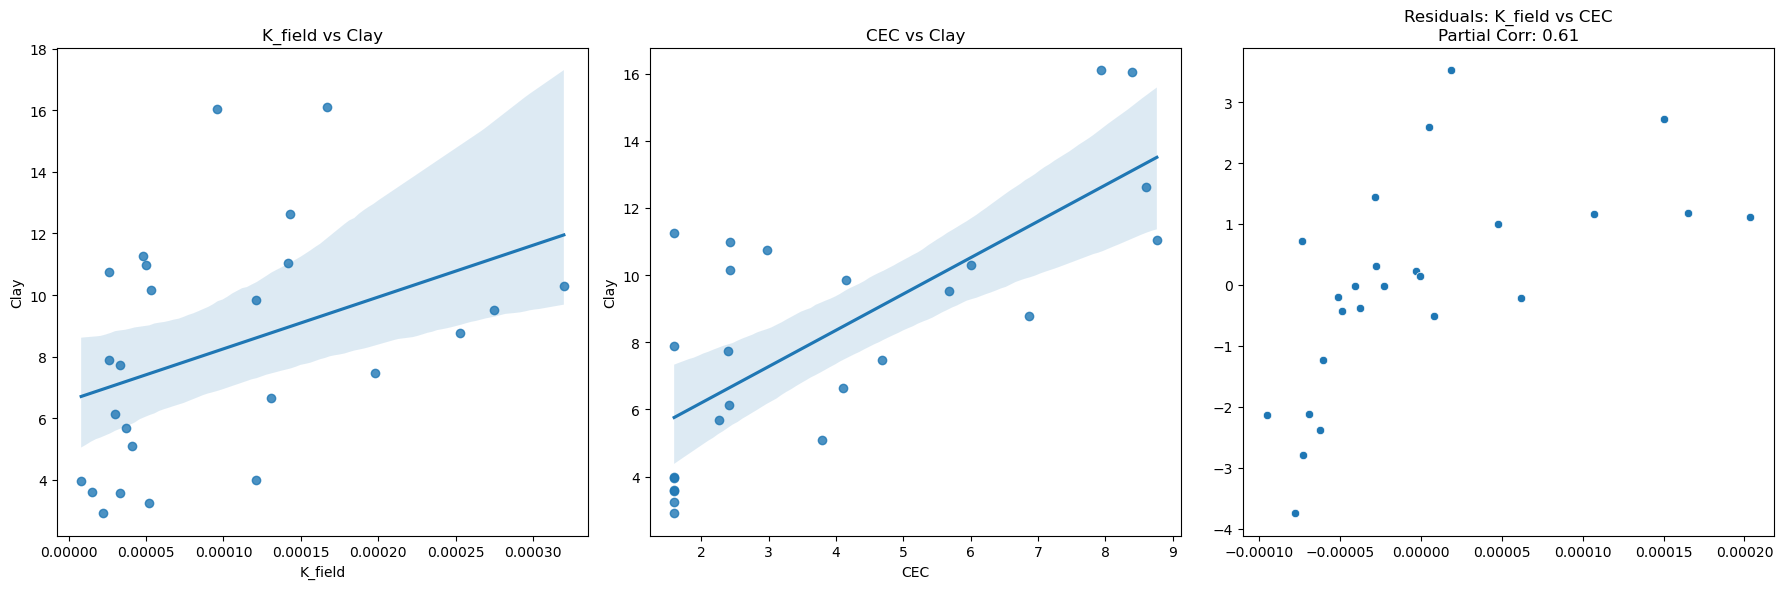

Correlation Matrix:
                    Klf   K_field   Kfd_abs       Kfd     Depth  Bulk_density  \
Klf           1.000000  0.896844  0.971341 -0.047317 -0.301578     -0.458934   
K_field       0.896844  1.000000  0.883972 -0.018472 -0.403157     -0.483741   
Kfd_abs       0.971341  0.883972  1.000000  0.146923 -0.314412     -0.505385   
Kfd          -0.047317 -0.018472  0.146923  1.000000 -0.033096     -0.346923   
Depth        -0.301578 -0.403157 -0.314412 -0.033096  1.000000      0.433327   
Bulk_density -0.458934 -0.483741 -0.505385 -0.346923  0.433327      1.000000   
Humus         0.734757  0.679238  0.743077  0.113077 -0.675775     -0.560769   
pH_eau        0.258803  0.290664  0.245479 -0.103886  0.175168      0.329357   
Clay          0.520869  0.500674  0.502308 -0.017692  0.360593     -0.111538   
Sand         -0.655511 -0.629209 -0.643077  0.046923 -0.153935      0.396154   
Fe            0.590883  0.583414  0.550769 -0.132308  0.324803     -0.103077   
EC            0.444

In [12]:
# Drop rows with NaN values in the filtered features to handle NaNs
df_filtered = sandy_soil[filtered_features].dropna()

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(df_filtered, nan_policy='omit')

# Convert to DataFrame for easier plotting
correlation_matrix = pd.DataFrame(corr, index=filtered_features, columns=filtered_features)

partial_correlation(sandy_soil, 'K_field', 'CEC', ['Clay'])

print("Correlation Matrix:\n", correlation_matrix)

# Multiple regression
X = sm.add_constant(sandy_soil[['K_field', 'Clay']])

# Check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

In [13]:
sandy_test_errors_summary = []
sandy_train_errors_summary = []
best_n_sandy = []
sandy_results_summary = []

# Evaluate all feature sets
for feature_set in all_feature_sets:
    best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(sandy_soil, feature_set, sandy_soil['CEC'], iters=100)
    print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
    
    # Store results in lists for later use
    best_n_sandy.append(best_n)
    sandy_test_errors_summary.append(R2_test_pol)
    sandy_train_errors_summary.append(R2_train_pol)
    
    # Also store the results in a structured format for sorting
    sandy_results_summary.append({
        'feature_set': feature_set,
        'best_n': best_n,
        'R2_test_pol': R2_test_pol,
        'R2_train_pol': R2_train_pol,
        'RMSE_test_pol': RMSE_test_pol,
        'RMSE_train_pol': RMSE_train_pol
    })

# Keep the lists of feature sets, test errors, and train errors as they are for further use
best_feat_ind = sandy_test_errors_summary.index(max(sandy_test_errors_summary))
best_feat = all_feature_sets[best_feat_ind]  # Use all_feature_sets to match the order
best_feat_n = best_n_sandy[best_feat_ind]
print('best_feat_ind, best_feat, best_feat_n', best_feat_ind, best_feat, best_feat_n)

# This part remains the same: finding the best feature set and using it in `fit_and_plot`
fit_and_plot(sandy_soil, best_feat, 'CEC', best_feat_n, mapping, 10)

# Convert the results summary to a DataFrame for sorting and filtering
results_sandy = pd.DataFrame(sandy_results_summary)

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.407 0.531 1.854 1.669 ['Clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.463 0.497 1.788 1.719 ['Sand']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.458 0.59 1.847 1.517 ['K_field']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.032 0.416 2.363 1.84 ['Khf']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.092 0.0 2.535 2.473 ['Kfd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.13 0.332 2.344 1.976 ['Kfd_abs']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.092 0.0 2.535 2.473 ['Depth']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.092 0.0 2.535 2.473 ['Bulk_density']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [14]:
# This part rbest_featemains the same: finding the best feature set and using it in `fit_and_plot`
fit_and_plot(sandy_soil, ['Clay'], 'CEC', 1, mapping, 10)

model.coef_ [0.   0.49]
model.intercept_ -0.12546378910307343


c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [15]:
best_feat

['K_field', 'EC']

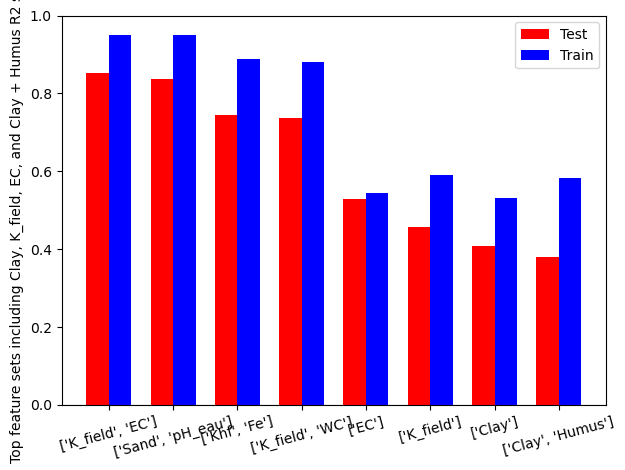

In [16]:

results_sandy.to_csv('table_outputs/full_results_sandy.csv')
# Sort by R2_test_pol in descending order and select the top 4
top_results_sandy = results_sandy.sort_values(by='R2_test_pol', ascending=False).head(n)

# Ensure that 'Clay', 'K_field', 'EC', and 'Clay + Humus' are included
required_features = [['Clay'], ['K_field'], ['EC'], ['Clay', 'Humus']]

# Find the corresponding results for the required features in the original results
for required in required_features:
    required_result = results_sandy[results_sandy['feature_set'].apply(lambda x: set(x) == set(required))]
    
    # Append the result for the required feature if it's not already in the top results
    if not required_result.empty and not any(set(required_result['feature_set'].values[0]) == set(x) for x in top_results_sandy['feature_set'].values):
        top_results_sandy = pd.concat([top_results_sandy, required_result])

# Now we ensure that the top 4 feature sets along with the required features are included in the plot
# Sort by R2_test_pol in descending order again to maintain consistency
top_results_sandy = top_results_sandy.sort_values(by='R2_test_pol', ascending=False)

# Plot the updated top results, which include the top 4 feature sets, and 'Clay', 'K_field', 'EC', and 'Clay + Humus'
bars_plot(top_results_sandy['feature_set'].tolist(), 
          top_results_sandy['R2_test_pol'].tolist(), 
          top_results_sandy['R2_train_pol'].tolist(), 
          'Top feature sets including Clay, K_field, EC, and Clay + Humus')

# CEC prediction with Train and Test for Clayey Group

Correlation Matrix:
                    Klf   K_field   Kfd_abs       Kfd     Depth  Bulk_density  \
Klf           1.000000  0.915778  0.941894  0.347467 -0.216228      0.569813   
K_field       0.915778  1.000000  0.898519  0.473020 -0.236831      0.607835   
Kfd_abs       0.941894  0.898519  1.000000  0.588338 -0.199391      0.631991   
Kfd           0.347467  0.473020  0.588338  1.000000  0.169639      0.634486   
Depth        -0.216228 -0.236831 -0.199391  0.169639  1.000000     -0.109637   
Bulk_density  0.569813  0.607835  0.631991  0.634486 -0.109637      1.000000   
Humus         0.068740 -0.084676  0.060949 -0.214006 -0.111401     -0.244942   
pH_eau       -0.334497 -0.255292 -0.318133 -0.092872 -0.218976      0.080681   
Clay          0.529796  0.445049  0.398694 -0.003914 -0.078312      0.106568   
Sand         -0.123097 -0.059848  0.019151  0.260491 -0.102676      0.415398   
Fe            0.287454  0.234117  0.109661 -0.297391 -0.079600      0.030876   
EC           -0.126

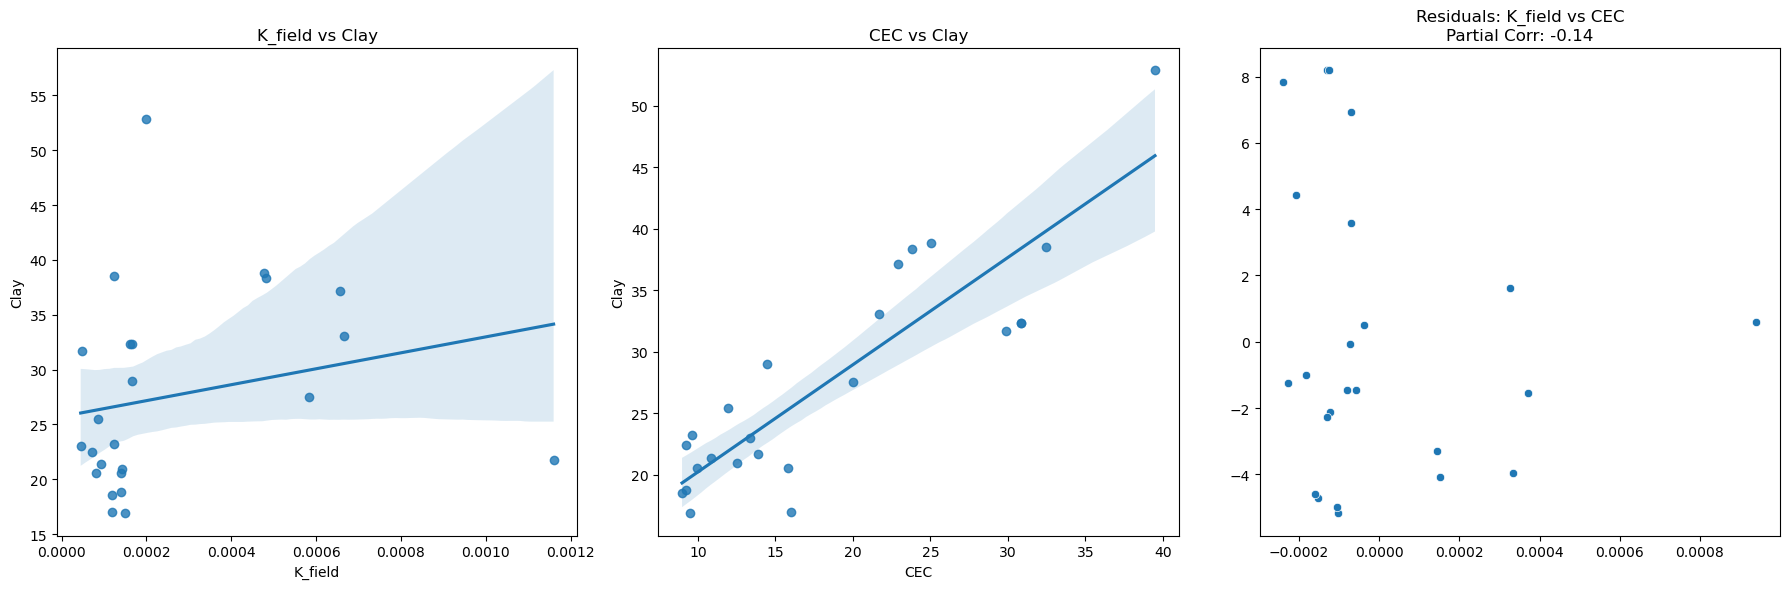

                            OLS Regression Results                            
Dep. Variable:                    CEC   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     35.73
Date:                Wed, 12 Feb 2025   Prob (F-statistic):           1.74e-07
Time:                        18:21:25   Log-Likelihood:                -68.612
No. Observations:                  24   AIC:                             143.2
Df Residuals:                      21   BIC:                             146.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7242      3.040     -1.883      0.0

In [17]:
# Drop rows with NaN values in the filtered features to handle NaNs
df_filtered = clayey_soil[filtered_features].dropna()

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(df_filtered, nan_policy='omit')

# Convert to DataFrame for easier plotting
correlation_matrix = pd.DataFrame(corr, index=filtered_features, columns=filtered_features)

print("Correlation Matrix:\n", correlation_matrix)

partial_correlation(clayey_soil, 'K_field', 'CEC', ['Clay'])
# Multiple regression
X = sm.add_constant(clayey_soil[['K_field', 'Clay']])
model = sm.OLS(clayey_soil['CEC'], X).fit()
print(model.summary())

# Check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

In [18]:
clayey_test_errors_summary = []
clayey_train_errors_summary = []
best_n_clayey = []
clayey_results_summary = []

# Evaluate all feature sets
for feature_set in all_feature_sets:
    best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(clayey_soil, feature_set, clayey_soil['CEC'], iters=100)
    print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
    
    # Store results in lists for later use
    best_n_clayey.append(best_n)
    clayey_test_errors_summary.append(R2_test_pol)
    clayey_train_errors_summary.append(R2_train_pol)
    
    # Also store the results in a structured format for sorting
    clayey_results_summary.append({
        'feature_set': feature_set,
        'best_n': best_n,
        'R2_test_pol': R2_test_pol,
        'R2_train_pol': R2_train_pol,
        'RMSE_test_pol': RMSE_test_pol,
        'RMSE_train_pol': RMSE_train_pol
    })

# Keep the lists of feature sets, test errors, and train errors as they are for further use
best_feat_ind = clayey_test_errors_summary.index(max(clayey_test_errors_summary))
best_feat = all_feature_sets[best_feat_ind]  # Use all_feature_sets to match the order
best_feat_n = best_n_clayey[best_feat_ind]
print('best_feat_ind, best_feat, best_feat_n', best_feat_ind, best_feat, best_feat_n)

# This part remains the same: finding the best feature set and using it in `fit_and_plot`
fit_and_plot(clayey_soil, best_feat, 'CEC', best_feat_n, mapping)

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 1 0.664 0.782 4.501 4.241 ['Clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 2 0.461 0.684 6.115 4.957 ['Sand']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['K_field']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Khf']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Kfd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Kfd_abs']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Depth']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 -0.113 0.0 8.661 9.045 ['Bulk_density']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 0 

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



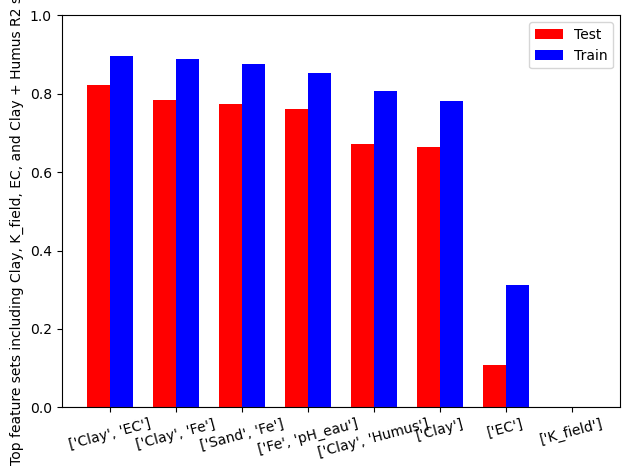

In [19]:
# Convert the results summary to a DataFrame for sorting and filtering
results_clayey = pd.DataFrame(clayey_results_summary)
results_clayey.to_csv('table_outputs/full_results_clayey.csv')

# Sort by R2_test_pol in descending order and select the top 4
top_results_clayey = results_clayey.sort_values(by='R2_test_pol', ascending=False).head(n)

# Ensure that 'Clay', 'K_field', 'EC', and 'Clay + Humus' are included
required_features = [['Clay'], ['K_field'], ['EC'], ['Clay', 'Humus']]

# Find the corresponding results for the required features in the original results
for required in required_features:
    required_result = results_clayey[results_clayey['feature_set'].apply(lambda x: set(x) == set(required))]
    
    # Append the result for the required feature if it's not already in the top results
    if not required_result.empty and not any(set(required_result['feature_set'].values[0]) == set(x) for x in top_results_clayey['feature_set'].values):
        top_results_clayey = pd.concat([top_results_clayey, required_result])

# Now we ensure that the top 4 feature sets along with the required features are included in the plot
# Sort by R2_test_pol in descending order again to maintain consistency
top_results_clayey = top_results_clayey.sort_values(by='R2_test_pol', ascending=False)

# Plot the updated top results, which include the top 4 feature sets, and 'Clay', 'K_field', 'EC', and 'Clay + Humus'
bars_plot(top_results_clayey['feature_set'].tolist(), 
          top_results_clayey['R2_test_pol'].tolist(), 
          top_results_clayey['R2_train_pol'].tolist(), 
          'Top feature sets including Clay, K_field, EC, and Clay + Humus')

# Final plot relevant features for sandy and clayey group

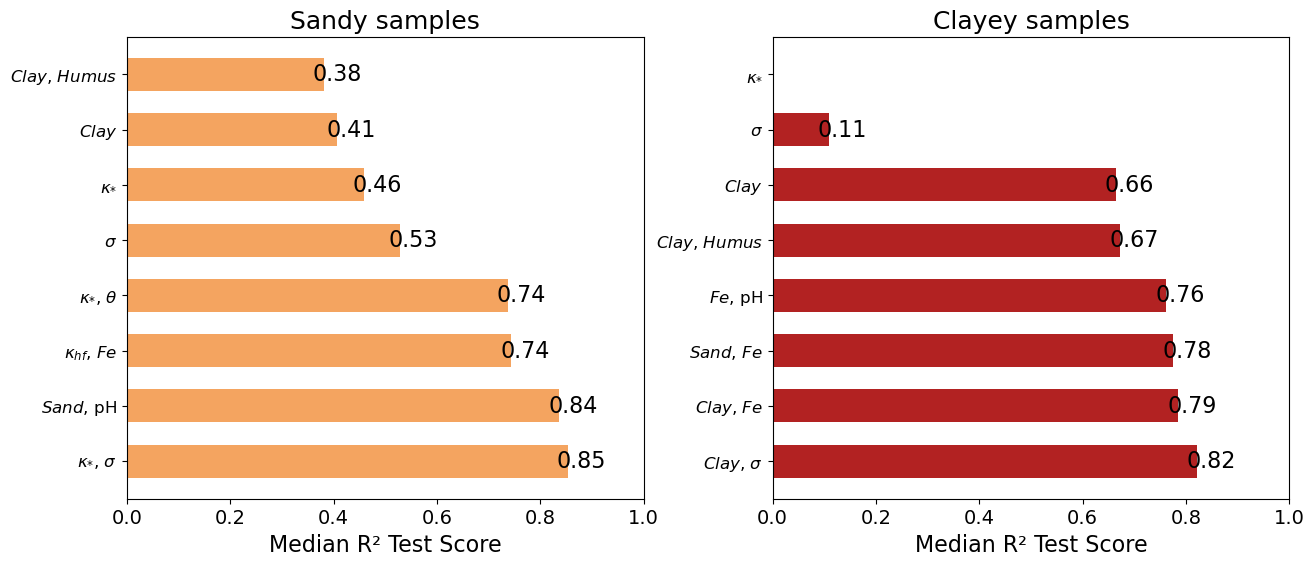

In [20]:
# Function to add text labels on bars
def add_labels(rects, ax):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.2f}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(10, 0),  # 10 points horizontal offset
                    textcoords="offset points",
                    ha='center', va='center',
                    fontsize=16)

# Data setup (assuming feature_sets_CEC, new_labels, and top_results are defined)
feature_sets_CEC = [
    ['Clay'], ['Sand'], ['K_field'], ['Khf'], ['Kfd'], ['Kfd_abs'],
    ['Depth'], ['Bulk_density'], ['Humus'], ['Fe'], ['EC'], ['pH_eau'], ['WC']
]

new_labels = [
    r'$\it{Clay}$', r'$\it{Sand}$', r'$\it{\kappa_{*}}$', r'$\it{\kappa_{hf}}$', 
    r'$\it{\kappa_{fd}}$', r'$\it{\kappa_{fd\,abs}}$', r'$\it{Depth}$', r'$\it{b_d}$', 
    r'$\it{Humus}$', r'$\it{Fe}$', r'$\it{\sigma}$', 'pH', r'$\it{\theta}$'
]

# Create a mapping for single features
single_features = [f[0] for f in feature_sets_CEC]
single_feature_to_label = {f: label for f, label in zip(single_features, new_labels)}

# Generate all pairs of features
pair_combinations = list(itertools.combinations(single_features, 2))
feature_sets_pairs = [[pair[0], pair[1]] for pair in pair_combinations]

# Generate labels for feature pairs by combining individual labels
pair_labels = [f'{single_feature_to_label.get(pair[0])}, {single_feature_to_label.get(pair[1])}' for pair in feature_sets_pairs]

# Combine individual features and pairs into one list
all_feature_sets = feature_sets_CEC + feature_sets_pairs
new_labels_extended = new_labels + pair_labels

# Create a dictionary to map feature sets to their corresponding labels
feature_to_label = {tuple(f): label for f, label in zip(all_feature_sets, new_labels_extended)}

# Reverse the order of feature sets and test errors if necessary
feature_sets_CEC = feature_sets_CEC[::-1]

# Assuming 'top_results_sandy' and 'top_results_clayey' contain feature_set info
n_sandy = len(top_results_sandy)
n_clayey = len(top_results_clayey)

# Define y positions for each set of features
y_sandy = np.arange(n_sandy)
y_clayey = np.arange(n_clayey)

# Ensure the feature sets in 'top_results_sandy' and 'top_results_clayey' are tuples
top_results_sandy_features = [tuple(fs) for fs in top_results_sandy.feature_set]
top_results_clayey_features = [tuple(fs) for fs in top_results_clayey.feature_set]

# Use the mapping to get the correct labels
sandy_labels = [feature_to_label.get(fs, "Unknown") for fs in top_results_sandy_features]
clayey_labels = [feature_to_label.get(fs, "Unknown") for fs in top_results_clayey_features]

# Set font sizes globally
plt.rcParams.update({'font.size': 16})

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.25)

# Plot for sandy soil
rects1 = plot_feature_importance(ax1, y_sandy, top_results_sandy.R2_test_pol, sandy_labels, title="Sandy samples", color='sandybrown')

# Plot for clayey soil
rects2 = plot_feature_importance(ax2, y_clayey, top_results_clayey.R2_test_pol, clayey_labels, title="Clayey samples", color='firebrick')

# Add the labels for both plots
add_labels(rects1, ax1)
add_labels(rects2, ax2)

# Save and show plot
plt.savefig('figures_output/barplot.png', dpi=300)
plt.show()